In [1]:
from fake_worm import *
import numpy as np
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os
import json

# Testing deterministic policy on fake environment

In [22]:
def det_policy(obs):
    # Returns 0 if obs is nans.
    # Otherwise, returns the known deterministic policy.
    if np.isnan(obs[0]):
        return 0
    body_dir,head_body = obs
    if body_dir*head_body < 0:
        action = 1
    elif body_dir == 0:
        if head_body == 0:
            action = 1
        else:
            action = 0
    else:
        action = 0
    return action

In [23]:
fbase = 'Data/test_'
env = FakeWorm()
eps_per_worm = 8

curr_ep = 0
WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    obs = env.reset()
    
    while not done:
        obs, r, done, info = env.step(action)
        print('{}\t r:{}\t\t\r'.format(obs,round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Chooses action for next step
        action = det_policy(obs)
        
    np.savez(fname, **trajectory)
    
env.close()

In [24]:
traj_tot = {}
for i in range(8):
    traj = np.load('Data/test_'+str(i)+'.npz',allow_pickle=True)
    add_to_traj(traj_tot,traj)

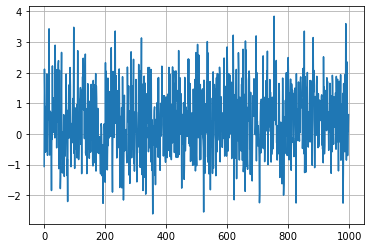

In [7]:
plt.plot(traj_tot['reward'][2])
plt.grid();

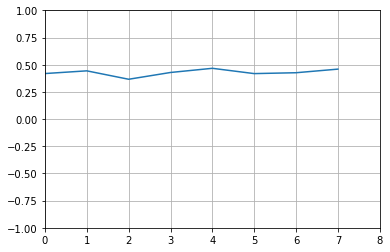

In [25]:
av_rew = [np.sum(traj_tot['reward'][i])/1000 for i in range(8)]
plt.axis([0,8,-1,1])
plt.plot(av_rew)
plt.grid();


# Random

In [8]:
fbase = 'Data/test_'
env = FakeWorm()
eps_per_worm = 8

curr_ep = 0
WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    obs = env.reset()
    
    while not done:
        action = env.action_space.sample()
        obs, r, done, info = env.step(action)
        print('{}\t r:{}\t\t\r'.format(obs,round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
    np.savez(fname, **trajectory)
    
env.close()

In [9]:
traj_tot = {}
for i in range(8):
    traj = np.load('Data/test_'+str(i)+'.npz',allow_pickle=True)
    add_to_traj(traj_tot,traj)

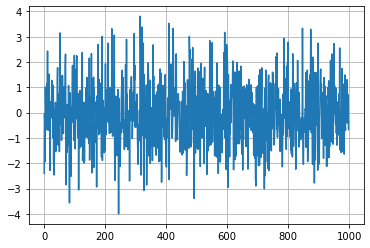

In [10]:
plt.plot(traj_tot['reward'][2])
plt.grid();

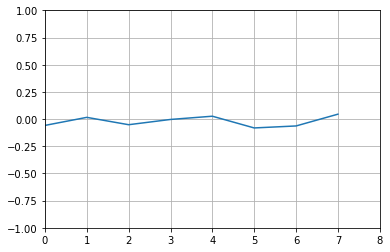

In [12]:
av_rew = [np.sum(traj_tot['reward'][i])/1000 for i in range(8)]
plt.axis([0,8,-1,1])
plt.plot(av_rew)
plt.grid();


# Q agent

In [2]:
class QTab_Agent():
    """
    General Q table agent.
    """
    def __init__(self,SA_discrete=(12,12,2),alpha=0.01,gamma=0.5,eps=0.1):
        # SA_discrete is (state0, state1, action) sizes
        # alpha is learning step size
        # gamma is discount factor
        # eps is the proportion of time random actions are selected
        
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.qtab = np.random.normal(scale=0.1,size=SA_discrete)
        self.obs_count = np.zeros(SA_discrete)
        
    def load(self,fname):
        chkpt = np.load(fname,allow_pickle=True)
        self.alpha = chkpt['alpha']
        self.gamma = chkpt['gamma']
        self.eps = chkpt['eps']
        
        self.qtab = chkpt['qtab']
        self.obs_count = chkpt['count']
        
    def learn(self, obs, obs_next, act, reward, DEG_STEP=30):
        # Takes obs_t, act_t, r_{t+1} and updates table if all values are valid.
        # DEG_STEP is the angle increment for discretizing states
        
        # Q table update step:
        # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
        
        if np.isnan(obs[0]) or np.isnan(obs_next[0]):
            return
        
        i_obs = self.obs2ind(obs)
        i_obs_next = self.obs2ind(obs_next)
        
        # Update rule and update count
        self.qtab[i_obs[0],i_obs[1],act] = self.qtab[i_obs[0],i_obs[1],act] + \
            self.alpha*(reward+self.gamma*np.max(self.qtab[i_obs_next[0],i_obs_next[1],:])
                  - self.qtab[i_obs[0],i_obs[1],act])
        self.obs_count[i_obs[0],i_obs[1],act] += 1
        
    def sample(self, obs):
        # Finds the best action for a given state.
        # eps of the time, returns a random choice for exploration.
        if np.isnan(obs[0]):
            return 0
        if np.random.uniform() < self.eps:
            return np.random.randint(0,2)
        i_obs = self.obs2ind(obs) 
        return np.argmax(self.qtab[i_obs[0],i_obs[1],:])
        
    def obs2ind(self,obs):
        # Maps [-180,180] to [0,11].
        # Must take valid obs (no nans)
        i_obs = np.zeros(2)
        for i in range(2):
            if obs[i]==180:
                i_obs[i] = -180
            i_obs[i] = int((obs[i]+180)/30)
        return i_obs.astype(int)
    
    def save(self,fname):
        # Saves agent as npz file with keys 'qtab' and 'count'.
        agent_dict = {
            'qtab':self.qtab,
            'count':self.obs_count,
            'eps':self.eps,
            'alpha':self.alpha,
            'gamma':self.gamma
        }
        np.savez(fname,**agent_dict)

In [15]:
fbase = 'Data/test_'
env = FakeWorm()
eps_per_worm = 200

curr_ep = 0
WORM_NUMBER = 0

agent = QTab_Agent(alpha=0.05,gamma=0,eps=0.001)

for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    print('{}\r'.format(i_episode),end='')
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    old_obs = env.reset()
    
    while not done:
        obs, r, done, info = env.step(action)
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Trains agent and chooses action for next step
        agent.learn(old_obs,obs,action,r)
        action = agent.sample(obs)
        old_obs = obs
        
    np.savez(fname, **trajectory)
    
env.close()

In [18]:
traj_tot = {}
for i in range(eps_per_worm):
    traj = np.load('Data/test_'+str(i)+'.npz',allow_pickle=True)
    add_to_traj(traj_tot,traj)

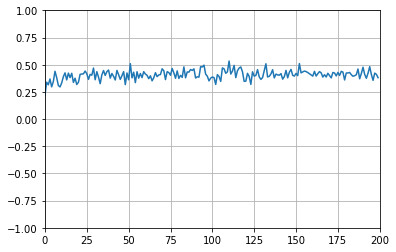

In [19]:
av_rew = [np.sum(traj_tot['reward'][i])/1000 for i in range(eps_per_worm)]
plt.axis([0,eps_per_worm,-1,1])
plt.plot(av_rew)
plt.grid();

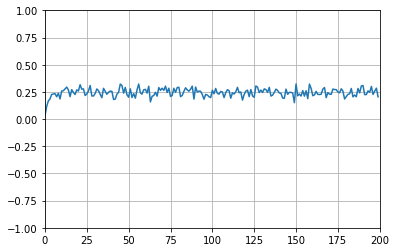

In [71]:
av_rew = [np.sum(traj_tot['reward'][i])/1000 for i in range(eps_per_worm)]
plt.axis([0,eps_per_worm,-1,1])
plt.plot(av_rew)
plt.grid();

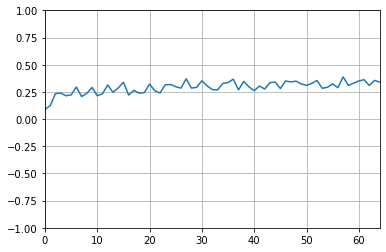

In [68]:
av_rew = [np.sum(traj_tot['reward'][i])/1000 for i in range(eps_per_worm)]
plt.axis([0,64,-1,1])
plt.plot(av_rew)
plt.grid();

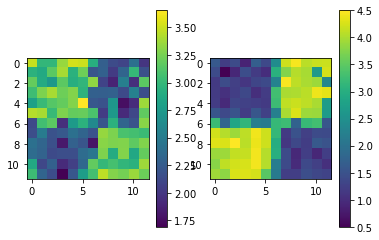

In [9]:
fig,ax = plt.subplots(1,2)
q0=ax[0].imshow(agent.qtab[:,:,0])
q1=ax[1].imshow(agent.qtab[:,:,1])
plt.colorbar(q0,ax=ax[0]);
plt.colorbar(q1,ax=ax[1]);

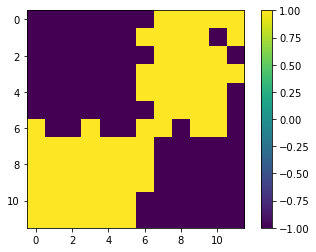

In [10]:
qdiff = agent.qtab[:,:,1]-agent.qtab[:,:,0]
qdiff = np.where(qdiff>0,1,qdiff)
qdiff = np.where(qdiff<0,-1,qdiff)
plt.imshow(qdiff)
plt.colorbar()

# SAC